In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display
import skimage.segmentation as seg
import skimage.color as color
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [3]:
img_name_1='Ultra_Co6_2-003.tif'
img_name_2='Ultra_Co11-2.tif'
img_name_3='06-abstract-microstrucure.JPG'
doggo='doggo.jpg'
door='door.jpg'

# Gaussian filter

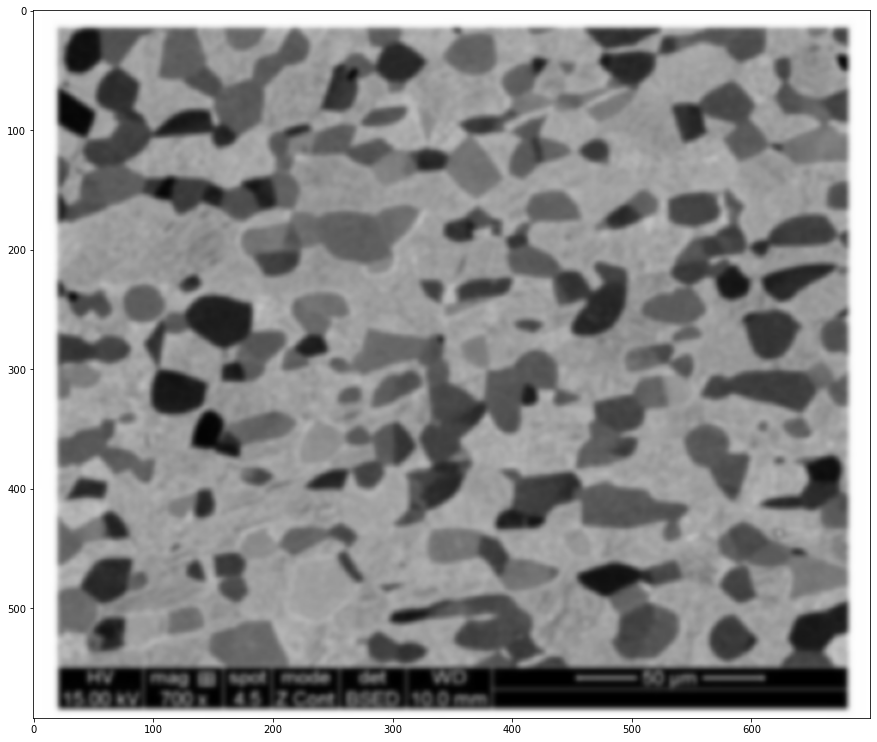

In [17]:
img = cv2.imread(img_name_3)
filtered=ndi.gaussian_filter(img,(2,2,2))
plt.figure(figsize=(15, 15))
plt.imshow(filtered)

# Otsu's binarization

In [78]:
def do_threshold(image_name,N=50):
    img = cv2.imread(image_name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(N,N)
    )
    ax1.imshow(img)
    ax2.imshow(thresh)
    
    ax1.set_title(image_name,fontsize=N)
    ax2.set_title(image_name+' ret='+str(ret),fontsize=N)

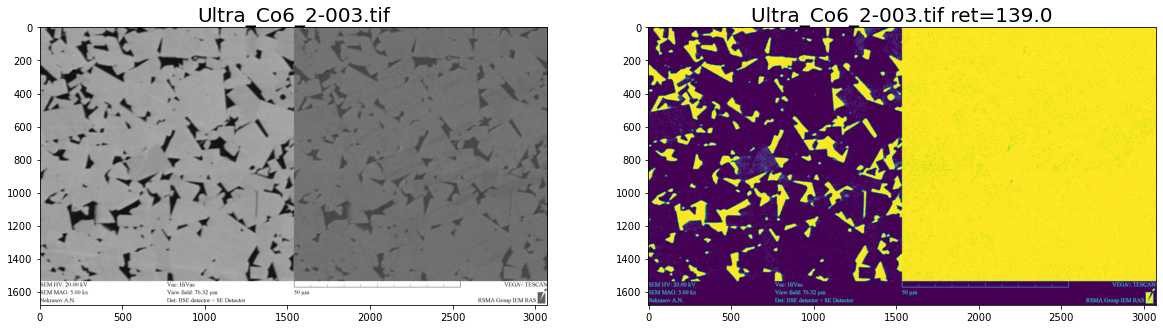

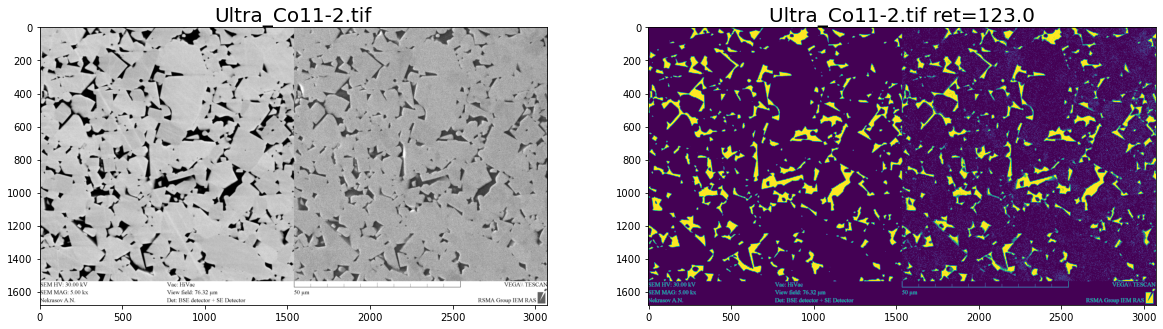

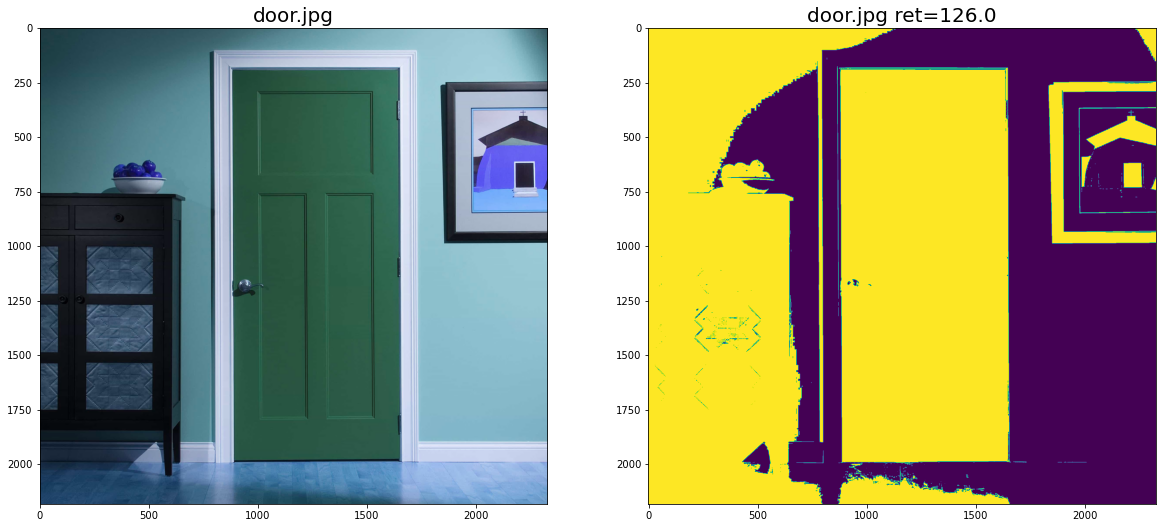

In [79]:
do_threshold(img_name_1,20)
do_threshold(img_name_2,20)
do_threshold(door,20)

# Watershed 

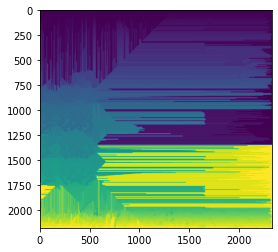

In [76]:
img = cv2.imread(door, cv2.IMREAD_GRAYSCALE);
distance = ndi.distance_transform_edt(img)
local_maxi = peak_local_max(distance, labels=img,
                            footprint=np.ones((3, 3)),
                            indices=False)
markers = ndi.label(local_maxi)[0]
labels = seg.watershed(-distance, markers, mask=img)
plt.imshow(labels)

In [109]:
def do_watershed(image_name,N=50):
    img = cv2.imread(image_name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 10)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    
    
    fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(N,N)
    )
    ax1.imshow(sure_fg)
    ax2.imshow(unknown)
    
    ax2.set_title(image_name,fontsize=N)
    ax1.set_title(image_name+' ret='+str(ret),fontsize=N)

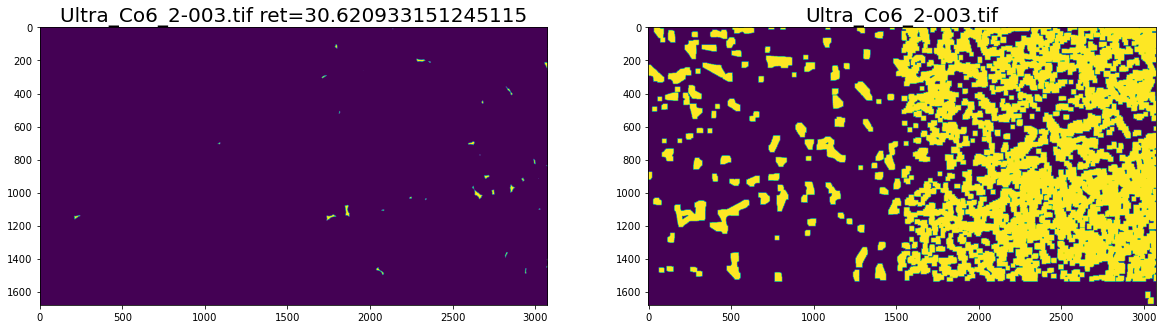

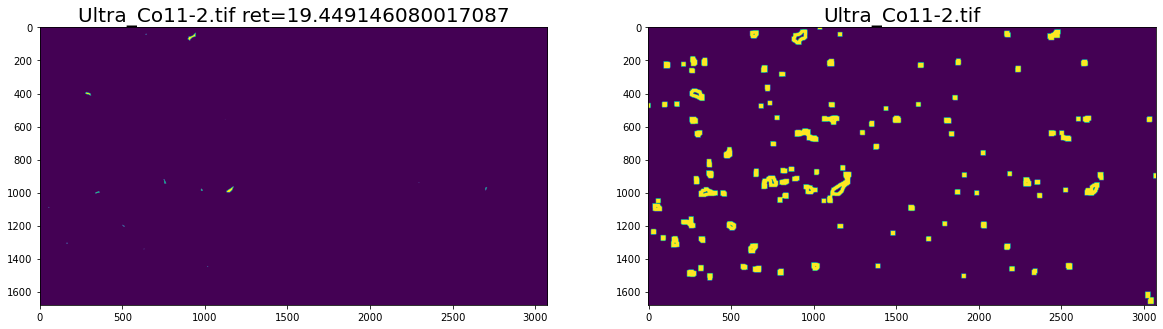

In [113]:
do_watershed(img_name_1,20)
do_watershed(img_name_2,20)

# Floodfill


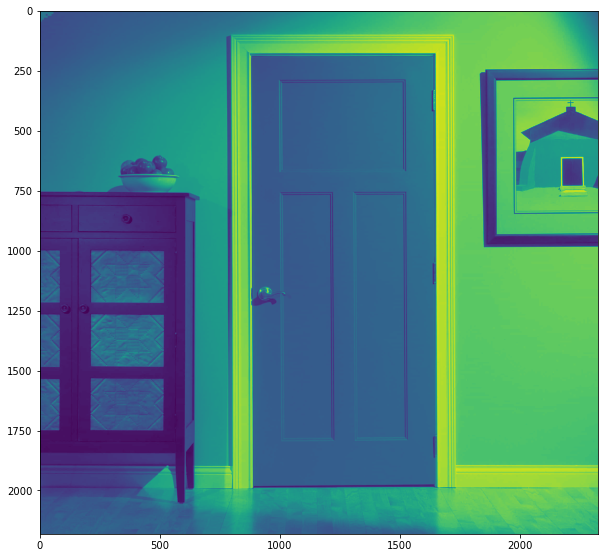

In [81]:
img = cv2.imread(door, cv2.IMREAD_GRAYSCALE);
new_img=seg.flood_fill(img,(1,1),100)
N=10
plt.figure(figsize=(N, N))
plt.imshow(new_img)

In [32]:
def do_floodfill(image_name,N=50):
    # Read image
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE);
    N=20
    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.
    th, im_th = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 150);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    # Display images.

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(
        nrows=4, ncols=1,
        figsize=(N,N)
        )

    ax1.imshow(im_th)
    ax1.set_title("Thesholded")
    ax2.imshow(im_floodfill)
    ax2.set_title("Floodfilled Image")
    ax3.imshow(im_floodfill_inv)
    ax3.set_title("Inverted Floodfilled Image")
    ax4.imshow(im_out)
    ax4.set_title("Foreground")

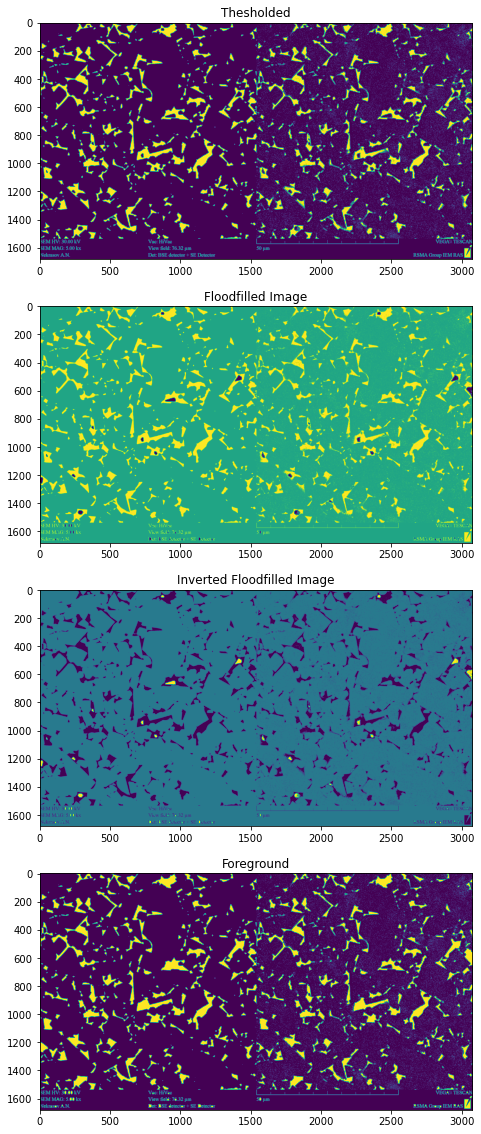

In [34]:
do_floodfill(img_name_2,N=20)

# K-means

In [4]:
def do_kmeans(img_name,N=20,K=10):
    img = cv2.imread(img_name)
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 50
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    fig, ax1 = plt.subplots(
        nrows=1, ncols=1,
        figsize=(N,N)
        )

    ax1.imshow(res2)
    ax1.set_title("K-means")

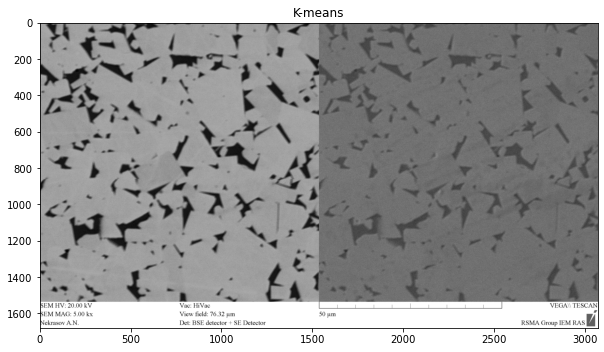

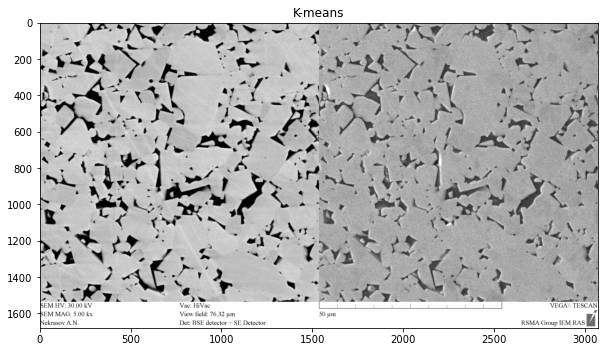

In [5]:
do_kmeans(img_name=img_name_1,N=10,K=10)
do_kmeans(img_name=img_name_2,N=10,K=10)

# Felzenszwalb

7471

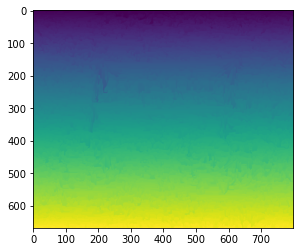

In [50]:
img = cv2.imread(doggo)
image_f = seg.felzenszwalb(img) 
plt.imshow(image_f)
np.unique(image_f).size

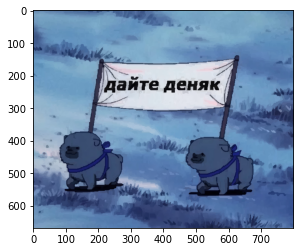

In [52]:
image_f_c = color.label2rgb(image_f, img, kind='avg')
plt.imshow(image_f_c)